*This is the initial implementation of the problem following meeting 2*

### Extracted Story
~~Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.~~

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.

### Assumptions
* There is only one messenger.
* "Enemy" and "Enemy City" are taken to refer to the same idea.
* A "reasonable plan" is assumed to mean that which wins a majority vote.
* The enemy/city is taken to have no functionality other than just "existing".
  * A city is assumed to be objectively either "attackable" or not, i.e., all generals make the same observations on the same city.
* A traitorous general simply "lies" to the other generals, i.e., he communicates the opposite of his observations to all generals.
* The observations that generals can make are either "attack" or "retreat".

### Design Decisions
* Enemy cities are simply instances of a class that essentially does nothing (yet).
* Each general works by first making an "objective" decision on an enemy. This is his true observation and not necessarily the one he communicates to the others.

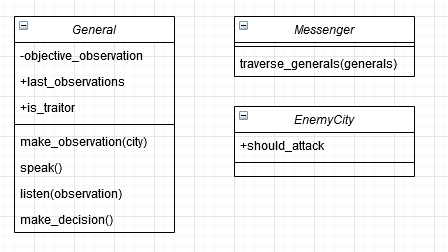

In [101]:
import random
from itertools import combinations
from collections import Counter

import networkx as nx
import matplotlib.pyplot as plt

In [102]:
SHOULD_ATTACK = False      # None for random
TOTAL_GENERALS = 5         # -1 for random
PERCENTAGE_TRAITORS = 0.4  # -1 for random

In [103]:
class EnemyCity:
    def __init__(self, should_attack):
        self.should_attack = should_attack

In [104]:
class General:
    next_id = 0
    
    def __init__(self, is_traitor=False):
        self._objective_observation = None
        self.last_observations = []
        self.is_traitor = is_traitor
        
        # Used for graphing
        self._id = General.next_id
        General.next_id += 1
    
    def make_observation(self, city: EnemyCity):
        self._objective_observation = ('retreat', 'attack')[city.should_attack]
    
    def speak(self):
        if not self.is_traitor:
            return self._objective_observation
        
        if self._objective_observation == 'attack':
            return 'retreat'
        
        return 'attack'
    
    def listen(self, observation):
        self.last_observations.append(observation)
    
    def make_decision(self):
        return Counter(self.last_observations).most_common(1)[0][0]
    
    def __repr__(self):
        return str(self._id)

In [110]:
class Messenger:
    @staticmethod
    def traverse_generals(generals):
        G = nx.DiGraph()
        labels = {}
        
        for x, y in combinations(generals, 2):
            y_speak = y.speak()
            x_speak = x.speak()
            
            x.listen(y_speak)
            y.listen(x_speak)
            
            labels[(x,y)] = f'{x_speak[0]}|{y_speak[0]}'
            G.add_edges_from([(x, y), (y, x)])
        
        return G, labels

In [106]:
def main():
    if PERCENTAGE_TRAITORS != -1:
        num_traitors = int(TOTAL_GENERALS * PERCENTAGE_TRAITORS)
    else:
        num_traitors = int(TOTAL_GENERALS * random.random())
    
    generals = [General(False) for _ in range(TOTAL_GENERALS - num_traitors)] + \
               [General(True) for _ in range(num_traitors)]
    
    if SHOULD_ATTACK:
        city = EnemyCity(SHOULD_ATTACK)
    else:
        city = EnemyCity(random.choice([True, False]))
    
    print(
        f'Running with {TOTAL_GENERALS} total generals of which'
        f' {num_traitors} are traitorous. EnemyCity.should_attack == {city.should_attack}\n\n'
    )
    
    # Each general makes an objective observation
    for g in generals:
        g.make_observation(city)
    
    # Each general communicates his observation (or not)
    m = Messenger()
    G, G_labels = m.traverse_generals(generals)
    
    # Each general comes up with a plan of action
    loyal_poa = set()
    
    for x, g in enumerate(generals):
        decision = g.make_decision()
        
        if not g.is_traitor:
            loyal_poa.add(decision)
            
#         print(
#             f'General {g._id} {"(traitor)" if g.is_traitor else "(loyal)":>9}'
#             f' says {decision.upper():>7} based on {g.last_observations:}'
#         )
    
    if len(loyal_poa) != 1:
        print('\nLoyal Generals cannot agree on a plan of action!!!')
    else:
        print(f'\nLoyal Generals have agreed on: {loyal_poa.pop()}')
    
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, node_color=['tab:red' if g.is_traitor else 'tab:blue' for g in G.nodes()])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=G_labels)

    plt.show()

Running with 5 total generals of which 2 are traitorous. EnemyCity.should_attack == False



Loyal Generals have agreed on: retreat


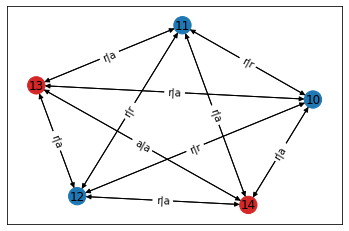

In [111]:
if __name__ == '__main__':
    main()